### 加载库

In [ ]:
import pandas as pd
import pickle
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

### 导入Test1数据

In [2]:
full_features = pd.read_table('./src/Test1_features.dat',sep = ',',header=None)
labels =  pd.read_table('./src/Test1_labels.dat',sep = ',', header=None)

In [3]:
print (full_features.shape)
full_features.head()

(20536, 61)


,0,1,2,3,4,5,6,7,8,9,...,51,52,53,54,55,56,57,58,59,60
0,0.002690,0.002630,0.002743,0.002506,0.002737,0.002791,0.002590,0.002726,0.002484,0.002841,...,-0.002815,0.000849,0.001611,-0.000375,-0.000097,0.000300,-0.000327,-0.000777,0.000558,-0.001546
1,0.002719,0.002617,0.002737,0.002715,0.002794,0.002601,0.002636,0.002523,0.002591,0.002842,...,-0.000097,0.000300,-0.000327,-0.000777,0.000558,-0.001546,0.000802,-0.000707,-0.001041,0.001237
2,0.003065,0.002631,0.002710,0.002841,0.002624,0.002595,0.002575,0.002562,0.002568,0.002805,...,0.000558,-0.001546,0.000802,-0.000707,-0.001041,0.001237,0.000635,-0.001843,0.000294,0.004381
3,0.002838,0.002867,0.002596,0.002727,0.002702,0.002556,0.002524,0.002426,0.002515,0.002871,...,-0.001041,0.001237,0.000635,-0.001843,0.000294,0.004381,-0.002215,0.000085,-0.000257,0.000111
4,0.002715,0.002743,0.002506,0.002737,0.002791,0.002590,0.002726,0.002484,0.002841,0.002876,...,0.000294,0.004381,-0.002215,0.000085,-0.000257,0.000111,-0.001733,0.000205,0.000983,-0.000687


In [4]:
print (labels.shape)
labels.head()

(20536, 1)


,0
0,0
1,0
2,0
3,0
4,0


## Random Forest 模型
>由于数据集中 features 数目较多, 选用Random Forest可以有效地降低 irrelevant features 的影响
## 使用Grid Search来优化参数
选取的两个待优化参数为:  
* n_estimators: 树的数量 50~100
* max_depth: 树的最大深度 5~50  
这两个参数有低变高时都可以有效地 降低 training loss, 但如果太高了, 就会导致 overfitting, 所有需要找到一个合适的取值.

本次Grid Search 采用了 5-fold cross validation来优化参数,判断标准为 **AUC value**. 

注意: 本次 Training过程使用了 8 个 cpu core, 总耗时约 9 分钟.  
    电脑CPU较差请勿运行, 请直接使用 pickle load 已保存在 **output_q1** 文件夹下的 *rf_GridSearchCV.pickle* 文件

In [5]:
%%time
tuneParams ={"n_estimators":range(50,151,10), "max_depth":range(5,51,5) }
rf_GridSearch= GridSearchCV(estimator =RandomForestClassifier(
    min_samples_split=100,min_samples_leaf=20,max_features='sqrt',random_state=1117),
                       param_grid =tuneParams,scoring='roc_auc',cv=5,n_jobs=-1, return_train_score=True)
rf_GS = rf_GridSearch.fit(full_features.values,labels.values.ravel())

Wall time: 8min 51s


In [ ]:
# with open('./output_q1/rf_GridSearchCV.pickle', 'rb') as f:
#     rf_GS = pickle.load(f)
#     print (rf_GS)

In [10]:
f = open("./output_q1/output.txt","w")
f.write("By Grid Search, we got the best parameters {}.\nThe model with best parameters has the highest CV AUC value: {}.\n".format(
    rf_GS.best_params_,rf_GS.best_score_))
print(rf_GS.best_params_,rf_GS.best_score_)

{'max_depth': 20, 'n_estimators': 100} 0.9924145819380104


In [11]:
best_rf =rf_GS.best_estimator_

In [12]:
f.write ("Below is the best Random Forest model's information:\n{}\n".format(best_rf))
print(best_rf)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=20, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=20, min_samples_split=100,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=1117, verbose=0,
            warm_start=False)


In [13]:
print (best_rf.predict( full_features.values))
f.close()

[0 0 0 ... 1 1 1]


### 使用pickle 保存已训练好的模型

In [14]:
with open('./output_q1/rf_GridSearchCV.pickle', 'wb') as f2:
    pickle.dump(rf_GS, f2)

In [15]:
# with open('./output_q1/rf_GridSearchCV.pickle', 'rb') as f:
#     rf_GS = pickle.load(f)
#     print (rf_GS)

In [16]:
with open('./output_q1/best_RandomForest_model.pickle', 'wb') as f1:
    pickle.dump(best_rf, f1)

In [17]:
# with open('./output_q1/best_RandomForest_model.pickle', 'rb') as f:
#     best_rf = pickle.load(f)
#     print (best_rf)

## 提取 参数与AUC 信息并画图

In [18]:
# print (rf_GS.cv_results_)

In [19]:
length = len(rf_GS.cv_results_['params'])

x = [rf_GS.cv_results_['params'][i]["n_estimators"] for i in range(length)]
y = [rf_GS.cv_results_['params'][i]["max_depth"] for i in range(length)]
z = rf_GS.cv_results_['mean_test_score']

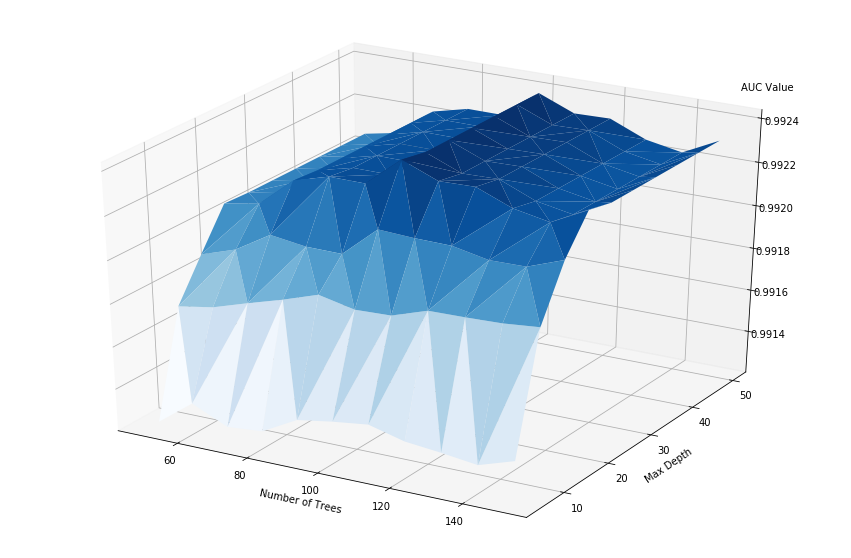

In [21]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111, projection='3d')
ax.plot_trisurf(x,y,z,cmap="Blues",linewidth=0.2, antialiased=True)
#ax.set_zlabel("AUC Value")
ax.text(155, 50,0.99255,"AUC Value")
plt.xlabel('Number of Trees')
plt.ylabel('Max Depth')

plt.show()

In [22]:
fig.savefig("./output_q1/result.png")